<a href="https://colab.research.google.com/github/DifferentiableUniverseInitiative/jax-cosmo-paper/blob/master/notebooks/DES_Y1_3x2pt_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Illustration of JAX-cosmo on a DES Y1-like analysis

In [1]:
# In this notebook we fix cosmo and nuissance parameters, only vary late-bin parameters

%pylab inline
import sys
sys.path.append('/global/homes/k/kunhaoz/des/projects/jax_cosmo_late_mod/') #common system
import os
import jax
import jax.numpy as np
import jax_cosmo as jc
import numpy as onp

os.environ["CUDA_VISIBLE_DEVICES"]="1"

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Retrieving  the nz data

In [2]:
# Let's grab the data file
from astropy.io import fits
if not os.path.isfile('2pt_NG_mcal_1110.fits'):
    !wget http://desdr-server.ncsa.illinois.edu/despublic/y1a1_files/chains/2pt_NG_mcal_1110.fits

nz_source=fits.getdata('2pt_NG_mcal_1110.fits', 6)
nz_lens=fits.getdata('2pt_NG_mcal_1110.fits', 7)

Text(0.5, 0, 'z')

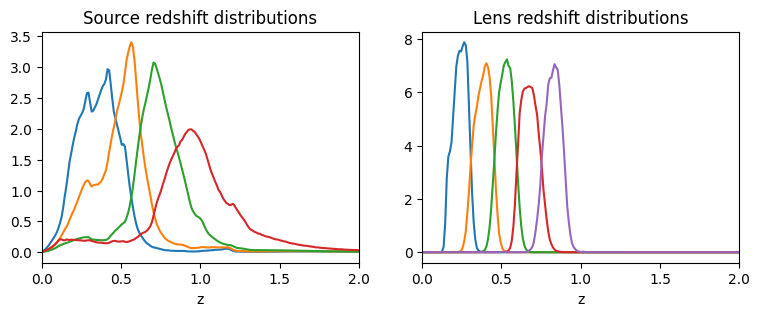

In [3]:
# Let's plot the NZs
figure(figsize=(9,3))
subplot(121)
plot(nz_source['Z_MID'], nz_source['BIN1'])
plot(nz_source['Z_MID'], nz_source['BIN2'])
plot(nz_source['Z_MID'], nz_source['BIN3'])
plot(nz_source['Z_MID'], nz_source['BIN4'])
xlim(0,2);
xlabel('z')
title('Source redshift distributions')
subplot(122)
plot(nz_lens['Z_MID'], nz_lens['BIN1'])
plot(nz_lens['Z_MID'], nz_lens['BIN2'])
plot(nz_lens['Z_MID'], nz_lens['BIN3'])
plot(nz_lens['Z_MID'], nz_lens['BIN4'])
plot(nz_lens['Z_MID'], nz_lens['BIN5'])
xlim(0,2);
title('Lens redshift distributions');
xlabel('z')

In [4]:
# Now let's try to build the equivalent with jax-cosmo

# This is the effective number of sources from the cosmic shear paper
neff_s = [1.47, 1.46, 1.50, 0.73]

nzs_s = [jc.redshift.kde_nz(nz_source['Z_MID'].astype('float32'),
                            nz_source['BIN%d'%i].astype('float32'), 
                            bw=0.01,
                            gals_per_arcmin2=neff_s[i-1])
           for i in range(1,5)]

nzs_l = [jc.redshift.kde_nz(nz_lens['Z_MID'].astype('float32'),
                              nz_lens['BIN%d'%i].astype('float32'), bw=0.01)
           for i in range(1,6)]

I0000 00:00:1704574807.805875 1587867 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


(0.0, 1.0)

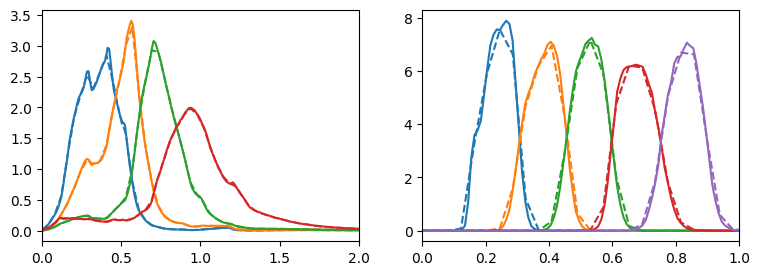

In [5]:
z = linspace(0,2)
figure(figsize=(9,3))
subplot(121)

for i in range(4):
    plot(nz_source['Z_MID'], nz_source['BIN%d'%(i+1)], color='C%d'%i)
    plot(z, nzs_s[i](z), '--', color='C%d'%i)

xlim(0,2)
subplot(122)

for i in range(5):
    plot(nz_lens['Z_MID'], nz_lens['BIN%d'%(i+1)], color='C%d'%i)
    plot(z, nzs_l[i](z), '--', color='C%d'%i)
xlim(0,1)

##  Let's build  a model for C_ell

In [6]:
# First, let's define a function to go to and from a 1d parameter vector
def get_params_vec(cosmo):

    return np.array([ 
        # KZ: late time mod parameters
        cosmo.a_late[0],cosmo.a_late[1], cosmo.a_late[2],cosmo.a_late[3], cosmo.a_late[4],
        cosmo.b_late[0],cosmo.b_late[1], cosmo.b_late[2],cosmo.b_late[3], cosmo.b_late[4]
    ])
    
def unpack_params_vec(params):
    # Retrieve cosmology
    cosmo = jc.Cosmology(sigma8=0.801,
                          Omega_c=0.2545,
                          Omega_b=0.0485,
                          h=0.682,
                          n_s=0.971,
                          w0=-1.0, # Fix w0=-1
                          Omega_k=0., wa=0.,
                         a_late=[params[0], params[1], params[2], params[3], params[4]], z_mod_form="bin_fixed",
                         b_late=[params[5], params[6], params[7], params[8], params[9]], k_mod_form="bin_fixed",)
    m1,m2,m3,m4 = [0.0,0.0,0.0,0.0]
    dz1,dz2,dz3,dz4 =  [0.0,0.0,0.0,0.0]
    A = 0.5
    eta = 0.0
    bias = [1.2, 1.4, 1.6, 1.8, 2.0]
    return cosmo, [m1,m2,m3,m4], [dz1,dz2,dz3,dz4], [A, eta], bias



In [7]:
# Define some ell range
ell = np.logspace(1, 3)

@jax.jit
def mu(params):
    # First unpack parameter vector
    cosmo, m, dz, (A, eta), bias = unpack_params_vec(params) 

    # Build source nz with redshift systematic bias
    nzs_s_sys = [jc.redshift.systematic_shift(nzi, dzi) 
                for nzi, dzi in zip(nzs_s, dz)]

    # Define IA model, z0 is fixed
    b_ia = jc.bias.des_y1_ia_bias(A, eta, 0.62)
    # Bias for the lenses
    b = [jc.bias.constant_linear_bias(bi) for bi in bias] 

    # Define the lensing and number counts probe
    probes = [jc.probes.WeakLensing(nzs_s_sys, 
                                    ia_bias=b_ia,
                                    multiplicative_bias=m),
             jc.probes.NumberCounts(nzs_l, b)]
    cl = jc.angular_cl.angular_cl(cosmo, ell, probes)

    return cl

In [8]:
# Let's try it out
fid_cosmo = jc.Cosmology(sigma8=0.801,
                          Omega_c=0.2545,
                          Omega_b=0.0485,
                          h=0.682,
                          n_s=0.971,
                          w0=-1.0, # Fix w0=-1
                          Omega_k=0., wa=0.,
                          a_late=[0.0, 0.0, 0.0, 0.0, 0.0], z_mod_form="bin_fixed",
                          b_late=[0.0, 0.0, 0.0, 0.0, 0.0], k_mod_form="bin_fixed",
                        )

fid_params = get_params_vec(fid_cosmo)

/global/homes/k/kunhaoz/miniconda3/envs/jax-gpu/lib/python3.9/site-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


(50,)
[8.54456683e-09 8.05948641e-09 7.56174234e-09 7.05886238e-09
 6.55856658e-09 6.06632389e-09 5.58791990e-09 5.12699661e-09
 4.68696548e-09 4.27001234e-09 3.87777233e-09 3.51052232e-09
 3.16804671e-09 2.84988477e-09 2.55562704e-09 2.28463581e-09
 2.03623918e-09 1.81003756e-09 1.60553149e-09 1.42171064e-09
 1.25749744e-09 1.11202303e-09 9.83934156e-10 8.71552275e-10
 7.73131226e-10 6.86812551e-10 6.11052819e-10 5.44483458e-10
 4.85887053e-10 4.34405678e-10 3.89158011e-10 3.49171803e-10
 3.13683746e-10 2.82129292e-10 2.53938315e-10 2.28638622e-10
 2.05851863e-10 1.85250856e-10 1.66561723e-10 1.49564333e-10
 1.34072378e-10 1.19935020e-10 1.07027956e-10 9.52469076e-11
 8.45040427e-11 7.47249901e-11 6.58440941e-11 5.78024677e-11
 5.05459390e-11 4.40232954e-11]


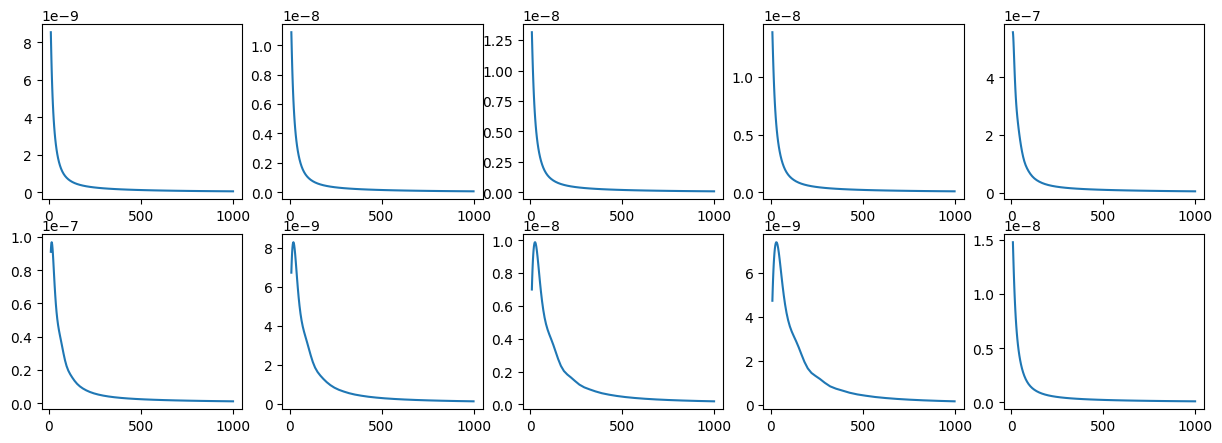

In [9]:
cl_3x2pt = mu(fid_params)

print(cl_3x2pt[0].shape)
print(cl_3x2pt[0])

fig, axes = plt.subplots(2, 5, figsize=(15, 5))
for i in range(2):
    for j in range(5):
        ax = axes[i][j]
        ax.plot(ell, cl_3x2pt[i*5 + j])

In [10]:
## Building a Fisher matrix, we just need the covarianc
@jax.jit
def cov(params):
    
    cl_signal = mu(params)
    
    # First unpack parameter vector
    cosmo, m, dz, (A, eta), bias = unpack_params_vec(params) 
    
    # Build source nz with redshift systematic bias
    nzs_s_sys = [jc.redshift.systematic_shift(nzi, dzi) 
                for nzi, dzi in zip(nzs_s, dz)]
    
    # Define IA model, z0 is fixed
    b_ia = jc.bias.des_y1_ia_bias(A, eta, 0.62)
    # Bias for the lenses
    b = [jc.bias.constant_linear_bias(bi) for bi in bias]
    
    # Define the lensing and number counts probe
    probes = [jc.probes.WeakLensing(nzs_s_sys, 
                                    ia_bias=b_ia,
                                    multiplicative_bias=m),
             jc.probes.NumberCounts(nzs_l, b)]
    
    cl_noise = jc.angular_cl.noise_cl(ell, probes)
    
    cov = jc.angular_cl.gaussian_cl_covariance(ell, probes, cl_signal, cl_noise, f_sky=0.25, 
                                               sparse=False)
    
    return cov

In [11]:
C = cov(fid_params)

print(C.shape)

print(onp.where(C==0))

print(C[0][onp.where(C[0]!=0)])

(2250, 2250)
(array([   0,    0,    0, ..., 2249, 2249, 2249]), array([   1,    2,    3, ..., 2246, 2247, 2248]))
[7.86634337e-17 6.00644562e-17 7.24862143e-17 7.64840443e-17
 3.07084511e-15 5.02183123e-16 3.71319524e-17 3.85979381e-17
 2.60346942e-17 4.58629728e-17 5.53477665e-17 5.84003541e-17
 2.34478265e-15 3.83448242e-16 2.83525717e-17 2.94719423e-17
 1.98791188e-17 6.67940801e-17 7.04779653e-17 2.82970033e-15
 4.62748128e-16 3.42160845e-17 3.55669499e-17 2.39902627e-17
 7.43650326e-17 2.98576658e-15 4.88269972e-16 3.61032011e-17
 3.75285723e-17 2.53133976e-17 1.19878960e-13 1.96041100e-14
 1.44954866e-15 1.50677738e-15 1.01633641e-15 3.20590980e-15
 2.37048391e-16 2.46407152e-16 1.66204077e-16 1.75276098e-17
 1.82196059e-17 1.22893066e-17 1.89389238e-17 1.27744935e-17
 8.61652289e-18]


In [12]:
jacobian = jax.jit(jax.jacfwd(lambda p: mu(p).flatten()))

In [13]:
j = jacobian(fid_params)

In [14]:
%timeit jacobian(fid_params).block_until_ready()

15.6 ms ± 25.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [15]:
onp.savetxt('jacobian', j)

In [16]:
j.shape

(2250, 10)

In [17]:
import scipy

def symmetrized_matrix(U):
    u"""Return a new matrix like `U`, but with upper-triangle elements copied to lower-triangle ones."""
    M = U.copy()
    inds = onp.triu_indices_from(M,k=1)
    M[(inds[1], inds[0])] = M[inds]
    return M



def symmetric_positive_definite_inverse(M):
    u"""Compute the inverse of a symmetric positive definite matrix `M`.

    A :class:`ValueError` will be thrown if the computation cannot be
    completed.

    """
    import scipy.linalg
    U,status = scipy.linalg.lapack.dpotrf(M)
    if status != 0:
        raise ValueError("Non-symmetric positive definite matrix")
    M,status = scipy.linalg.lapack.dpotri(U)
    if status != 0:
        raise ValueError("Error in Cholesky factorization")
    M = symmetrized_matrix(M)
    return M

In [18]:
j64 = onp.array(j).astype(onp.float64)
C64 = onp.array(C).astype(onp.float64)

In [19]:
# And we get the fisher matrix from the jacobian and covariance
CC = symmetric_positive_definite_inverse(C64)
F = onp.einsum('ia,ij,jb->ab', j64, CC, j64)
F = 0.5*(F + F.T)

In [20]:
#KZ testing

#print(onp.diagonal(F))

print(j64[1])

[ 6.97461422e-09  1.16237131e-09  5.22311881e-12  2.12039956e-12
  9.16094891e-13  5.70256242e-09  1.51834179e-09  4.94922159e-10
  1.85287319e-09 -5.90805738e-10]


In [21]:
cov_estimate = symmetric_positive_definite_inverse(F)
onp.savetxt('cov_estimate_from_fisher.txt', cov_estimate)


In [22]:
def is_symmetric(X):
    return onp.all(X == X.T)

is_symmetric(F)

True

In [23]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def plot_contours(fisher, pos, i, j, nstd=1., ax=None, resize=False, **kwargs):
  """
  Plot 2D parameter contours given a Hessian matrix of the likelihood
  """
  
  def eigsorted(cov):
    vals, vecs = linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:, order]

  mat = fisher
  cov = np.linalg.inv(mat)
  sigma_marg = lambda i: np.sqrt(cov[i, i])

  if ax is None:
      ax = plt.gca()

  # Extracts the block we are interested in
  cov = cov[:,[i,j]][[i,j],:]
  vals, vecs = eigsorted(cov)
  theta = degrees(np.arctan2(*vecs[:, 0][::-1]))

  # Width and height are "full" widths, not radius
  width, height = 2 * nstd * sqrt(vals)
  xy = [pos[i], pos[j]]
  ellip = Ellipse(xy=xy, width=width,
                  height=height, angle=theta, **kwargs)

  ax.add_artist(ellip)
  if resize:
    sz = max(width, height)
    s1 = 1.5*nstd*sigma_marg(i)
    s2 = 1.5*nstd*sigma_marg(j)
    ax.set_xlim(pos[i] - s1, pos[i] + s1)
    ax.set_ylim(pos[j] - s2, pos[j] + s2)
  plt.draw()
  return ellip

In [24]:
fid_params

Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [25]:
print(F)

[[6.48707249e+05 3.30447333e+04 5.15680208e+04 4.90148288e+04
  2.87016591e+04 2.05016581e+04 7.24831202e+04 2.05426548e+05
  4.46658409e+05 3.38736163e+05]
 [3.30447333e+04 9.39560323e+03 3.33042422e+03 5.09494292e+00
  9.61249285e-02 1.30636949e+03 4.53666964e+03 1.38226771e+04
  3.12163023e+04 1.14929264e+04]
 [5.15680208e+04 3.33042422e+03 2.57689592e+04 1.66530933e+03
  2.12625197e+01 2.00561409e+03 6.83186911e+03 2.17387334e+04
  5.60681888e+04 4.24013728e+04]
 [4.90148288e+04 5.09494292e+00 1.66530933e+03 3.64968394e+04
  8.95984444e+03 2.20899947e+03 7.12442452e+03 2.27902252e+04
  6.06568631e+04 6.48660070e+04]
 [2.87016591e+04 9.61249285e-02 2.12625197e+01 8.95984444e+03
  2.65335841e+04 1.44183173e+03 4.59431619e+03 1.47076556e+04
  3.88183353e+04 4.35929780e+04]
 [2.05016581e+04 1.30636949e+03 2.00561409e+03 2.20899947e+03
  1.44183173e+03 3.54847609e+03 2.53856159e+03 6.34160881e+03
  1.28513721e+04 9.06369127e+03]
 [7.24831202e+04 4.53666964e+03 6.83186911e+03 7.12442452e

In [ ]:
names = ['a_late_1','a_late_2','a_late_3','a_late_4','a_late_5',
         'b_late_1','b_late_2','b_late_3','b_late_4','b_late_5',
        ]

nparam = len(names)
nplot = nparam
fig, axes = plt.subplots(nplot, nplot, figsize=(2*nplot,2*nplot), sharex=False, sharey=False)
pmin = [-0.1 for i in range(10)]
pmax = [0.1 for i in range(10)]
for i, name1 in enumerate(names[:]):
    for j, name2 in enumerate(names[:]):
        if i>=nplot or j >= nplot:
            continue
        ax = axes[i, j]
        if i < j:
            fig.delaxes(ax)
            continue
        if i == j:
            ax.set_xlim(pmin[i], pmax[i])
        else:
            plot_contours(F, fid_params, j, i, ax=ax, edgecolor='r', facecolor='none')
            ax.set_xlim(pmin[j], pmax[j])
            ax.set_ylim(pmin[i], pmax[i])
        if j == 0:
            ax.set_ylabel(name1)
        else:
            ax.get_yaxis().set_visible(False)

        if i == nplot-1:
            ax.set_xlabel(name2)
        else:
            ax.get_xaxis().set_visible(False)
subplots_adjust(wspace=0.05)
subplots_adjust(hspace=0.05)

In [ ]:
cov_param = symmetric_positive_definite_inverse(F)
print("is symmetric",is_symmetric(cov_param))

print("is hermitian", scipy.linalg.ishermitian(cov_param))

In [ ]:
figure(figsize=(10,10))
# Here we convert the covariance matrix from sparse to dense reprensentation
# for plotting
imshow(cov_param);
plt.colorbar()

In [ ]:
eig_vals, eig_vecs = np.linalg.eigh(cov_param)

In [ ]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=False)

# Confirm that the list is correctly sorted by ascending eigenvalues
print('Eigenvalues in ascending order:')
for i in eig_pairs:
    print(i[0])
    
# Select first two PC
PC1 = onp.array(eig_pairs[0][1])
PC2 = onp.array(eig_pairs[1][1])
PC3 = onp.array(eig_pairs[2][1])

In [ ]:
print(PC1)

tmp=0
for i in range(len(PC1)):
    tmp = tmp + PC1[i]**2
print(tmp)

In [ ]:
plt.scatter(np.arange(0,10),PC1, marker='+', s=100)

In [ ]:
plt.scatter(np.arange(0,10),PC2, marker='+', s=100)

In [ ]:
onp.savetxt("PCA.txt",[PC1, PC2, PC3])

In [ ]:
bins=5

grid_1 = onp.zeros((bins,bins))

for i in range(bins):
    for j in range(bins):
        grid_1[i][j] = (1 + PC1[i]) * (1 + PC1[j+bins])
        
print(grid_1)
grid_1 = grid_1.T
imshow(grid_1, origin = 'lower')
plt.colorbar()
plt.xlabel("z bin")
plt.ylabel("k bin")

In [ ]:
bins=5

grid_2 = onp.zeros((bins,bins))

for i in range(bins):
    for j in range(bins):
        grid_2[i][j] = (1 + PC2[i]) * (1 + PC2[j+bins])
        
grid_2 = grid_2.T
imshow(grid_2, origin = 'lower')
plt.colorbar()
plt.xlabel("z bin")
plt.ylabel("k bin")

In [ ]:
bins=5

grid_3 = onp.zeros((bins,bins))

for i in range(bins):
    for j in range(bins):
        grid_3[i][j] = (1 + PC3[i]) * (1 + PC3[j+bins])
        
grid_3 = grid_3.T
imshow(grid_3, origin = 'lower')
plt.colorbar()
plt.xlabel("z bin")
plt.ylabel("k bin")

In [ ]:
j